# Running a SWMM-F Simulation [1]
### Importing required packages and libraries
A SWMM-V simulation is a model of IWS that includes the filling process and models consumers with a volume-restricted withdrawal 
In this notebook, we use PySWMM (a python wrapper for EPA's SWMM) to run a pre-prepared SWMM .inp file  
Alternatively, the .inp file can be run from SWMM's GUI if preferred and the output (.out) file can be imported directly for post-processing
**The packages and libraries to be imported are:**  
* **PySWMM** for parsing, running and outputting the results of a SWMM .inp file
* **LinkAttribute**, a module in PySWMM that extracts a specific attribute from the output results
* **Pandas & Numpy** for data handling and processing
* **datetime** for parsing and operating on datetime formats
* **re** for usign regular expressions to filter the results
* **matplotlib** for plotting and visulisation

In [3]:
import pyswmm
from pyswmm import swmm5
import re
from swmm.toolkit.shared_enum import NodeAttribute
import pandas as pd
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt

### Specifying paths for simulation files and preprocessing the input
**Warning:** *Paths in this script (and the rest of this repo) are absolute*  
For batch runs of multiple .inp files at once, please use the \[Script\] in \[Repo path\]  
Input filename (with extensions) as string.  

In [4]:
directory='/Users/omaraliamer/Desktop/UofT/Papers/Clean Network Files/SWMM/Final Files/'
filename='N3a_Campisano_10m_FORCE_MAIN_Vrestricted.inp'
name_only=filename[0:-4]
print("Selected File: ",name_only)
abs_path=directory+filename

Selected File:  N3a_Campisano_10m_FORCE_MAIN_Vrestricted


### Parsing .inp file and building the network model
PySWMM's Simulation module reads in a SWMM .inp file, parses it, and builds a network model object of the specified network  
SWMM typically produces a report file (containing specified reported results) and an output file (containing all results at all reporting time steps)  
PySWMM optionally allows for a path to be specified for each of those files, here we only need the output file (.out)

In [5]:
sim=pyswmm.Simulation (abs_path, outputfile=directory+name_only+".out")


 o  Retrieving project data

### Preprocessing
In a SWMM-V simulation, each demand node is connected to a Storage node corresponding to the desired demand volume
To later filter the results to include only the demand nodes, the IDs of the demand outlets are recorded

In [6]:
nodes=pyswmm.nodes.Nodes(sim)
tankids=[]
for node in nodes:
    if re.search('S',node.nodeid):
        tankids.append(node.nodeid)

### Running the SWMM simulation
PySWMM has two modes of running a SWMM simulation  
In this mode, we step through the simulation step by step, which allows for (if needed) displaying key information while the simulation runs  
e.g., you may want to check on a specific node's depth while the simulation runs  
In this case, we only display the simulations current time, to give the user a sense of how long it is going to take  
You may edit the upcoming cell to print any other information you want (refer to pyswmm's documentation [here](https://pyswmm.readthedocs.io/en/stable/))  
To get more frequent current time outputs, reduce the value of **every** (More frequent updates -> longer runtime)

In [7]:
stp=0       #steps counter
every=1000  #Interval of printing current time

# runs the simulation step by step
with sim as sim:
    for step in sim:
        if stp%every==0:
            print('Current Time is >> ',sim.current_time)
        stp+=1
        pass

Current Time is >>  2022-05-18 00:00:01
Current Time is >>  2022-05-18 00:16:41
Current Time is >>  2022-05-18 00:33:21
Current Time is >>  2022-05-18 00:50:01
Current Time is >>  2022-05-18 01:06:41
Current Time is >>  2022-05-18 01:23:21
Current Time is >>  2022-05-18 01:40:01
Current Time is >>  2022-05-18 01:56:41
Current Time is >>  2022-05-18 02:13:21
Current Time is >>  2022-05-18 02:30:01
Current Time is >>  2022-05-18 02:46:41
Current Time is >>  2022-05-18 03:03:21
Current Time is >>  2022-05-18 03:20:01
Current Time is >>  2022-05-18 03:36:41
Current Time is >>  2022-05-18 03:53:21


### Postprocessing & Extracting the Results
Using the Output module in PySWMM, we extract the time series results for each  of the demand nodes  
Satisfaction ratio can be extracted directly in this case, since storage nodes were set where the height of water in the tank corresponds to the percentage of demand satisfied  
i.e., a tank height of 0.5 m means that 50% of the demand is satisfied

In [8]:
Depths=pd.DataFrame()   #Empty Dataframe to store water depth in tanks
swtch=True              # switch variable for upcoming condition

# Reads the output file created above
with pyswmm.Output(directory+name_only+".out") as out:
    # loops through each node in output file
    for node in out.nodes:

        # One time only. Gets the timesteps (the keys in the output series dictionary) and stores them to be used as index
        if swtch:
        # node_series produces a dictionary with the keys corresponding to timestamps and values contain the value of the selected variable (FLOW_RATE) at each timestamp
            index=pd.Series(out.node_series(node,NodeAttribute.INVERT_DEPTH).keys())
            swtch=False
        
        # If node id is in the prepared list of demand nodes (tanks)
        if node in tankids:
            tsrs=pd.Series(out.node_series(node,NodeAttribute.INVERT_DEPTH).values())
            Depths=pd.concat([Depths,tsrs],axis=1)

Cleaning up the dataframe for further processing  
SWMM output files skip the initial time step in reporting the results. These have to be added back manually.  
The time stamp output of PySWMM is of datetime format, and is subsequently converted to seconds from start of simulation

In [9]:
# Stores the start time stamp of the simulation
start_time=index[0]
# List to store index of time in seconds (0 added as the missing initial time step)
new_index=[0]

# Loops through old index (datetime)
for time in index:
    # Gets time difference in seconds
    timesec=(time-start_time).seconds
    # Appends time in seconds to new index
    new_index.append(timesec+10)

# Sets all depths higher than 1 to 1 (Since any additional depth is due to the thin elongated portion of the tank curve, refer to methods section for more details)
Depths[Depths > 1]=1

### Formatting the DataFrame to add a zero row at the beginning (for the initial time step) and fix index and column names
Depths.index=new_index[1:]
Depths.columns=tankids
Depths=Depths.loc[~Depths.index.duplicated(keep='first')]
zeros=pd.DataFrame([0]*245).transpose()
zeros.index=[0]
zeros.columns=tankids
Depths=pd.concat([zeros,Depths])

# Calculates supply duration in minutes from the last entry in the new index (seconds)
supply_duration=new_index[-1]/60

In [10]:
# Intialize Series for storing statistics
mean=pd.Series(dtype='float64')
median=pd.Series(dtype='float64')
low_percentile=pd.Series(dtype='float64')
high_percentile=pd.Series(dtype='float64')

# Set the percentile values to be calculated
low_percent_val=10   # Range 0 to 100 ONLY
high_percent_val=90  # Range 0 to 100 ONLY

# Loop over each row (time step) in the results and calculate values of mean, median, low and high percentiles
for row in Depths.index:
    mean.loc[row]=np.mean(Depths.loc[row,:])*100
    low_percentile.loc[row]=np.percentile(Depths.loc[row,:],low_percent_val)*100
    median.loc[row]=np.percentile(Depths.loc[row,:],50)*100
    high_percentile.loc[row]=np.percentile(Depths.loc[row,:],high_percent_val)*100

### Result Visualisation
First we plot the Mean satisfaction in the network with time

<function matplotlib.pyplot.show(close=None, block=None)>

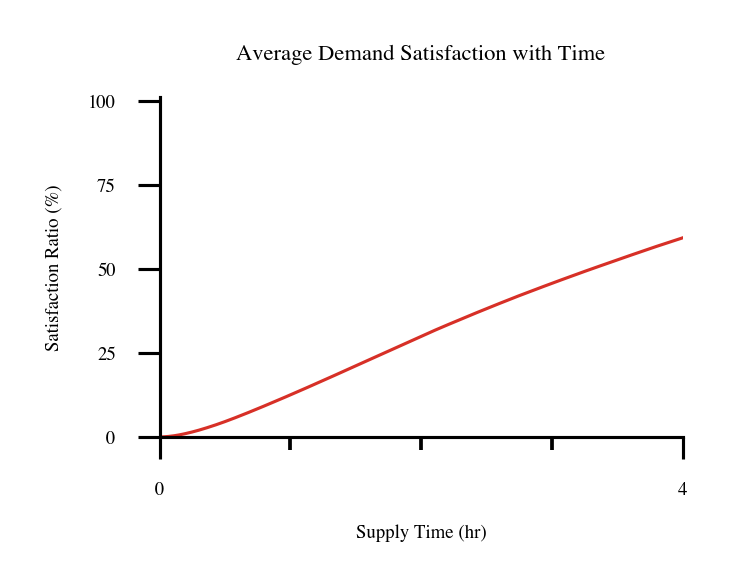

In [11]:
# Setting Universal Parameters for plotting: dots per inch (dpi), text font and size, label size
mpl.rcParams['figure.dpi'] = 450
font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 3}
mpl.rc('font', **font)
mpl.rc('xtick', labelsize=3)
mpl.rcParams['axes.linewidth'] = 0.5

# Prepping an xaxis with hr format
supply_duration_hr=supply_duration/60
xaxis=[x/3600 for x in new_index]

fig, ax=plt.subplots()
# Change figure size (and aspect ratio) by adjusting height and width here
fig.set_figwidth(1.5)
fig.set_figheight(1)

# Formatting Plot: Setting a Title, x- and y-axis limits, major and minor ticks
ax.set_title('Average Demand Satisfaction with Time')
ax.set_xlim(0,supply_duration_hr)
ax.set_ylim(0,101)
ax.set_xticks(np.arange(0,supply_duration_hr+1,4))
ax.set_xticks(np.arange(0,supply_duration_hr+1,1),minor=True)
ax.set_yticks(np.arange(0,101,25))
ax.tick_params(width=0.5)

# Data to be plotted: Mean as a percentage (hence the multiplication by 100)
# Change color by changing the string next to c= and linewidth by value
line1,=ax.plot(xaxis,mean, c='#d73027',linewidth=0.5)
plt.xlabel('Supply Time (hr)')
plt.ylabel('Satisfaction Ratio (%)')
# Optional: show grid or turn on and off spines (Plot box sides)
# ax.grid(visible=True,which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show

### Plotting the Distribution between Consumers (Equality)
Low Percentile, Median and High Percentile are plotted together to show the distribution between consumers with time. Area between Low and High Percentiles will be shaded

<function matplotlib.pyplot.show(close=None, block=None)>

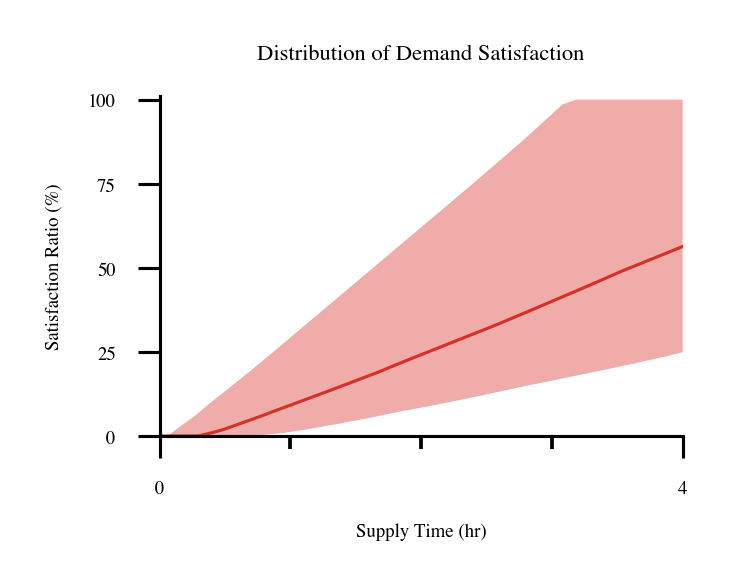

In [12]:
fig, ax=plt.subplots()
# Change figure size (and aspect ratio) by adjusting height and width here
fig.set_figwidth(1.5)
fig.set_figheight(1)

# Formatting Plot: Setting a Title, x- and y-axis limits, major and minor ticks
ax.set_title('Distribution of Demand Satisfaction')
ax.set_xlim(0,supply_duration_hr)
ax.set_ylim(0,101)
ax.set_xticks(np.arange(0,supply_duration_hr+1,4))
ax.set_xticks(np.arange(0,supply_duration_hr+1,1),minor=True)
ax.set_yticks(np.arange(0,101,25))
ax.tick_params(width=0.5)


# Data to be plotted: Mean as a percentage (hence the multiplication by 100)
# Change color by changing the string next to c= and linewidth by value
line1,=ax.plot(xaxis,median, c='#d73027',linewidth=0.5)
plt.fill_between(xaxis, y1=low_percentile, y2=high_percentile, alpha=0.4, color='#d73027', edgecolor=None)
plt.xlabel('Supply Time (hr)')
plt.ylabel('Satisfaction Ratio (%)')
# Optional: show grid or turn on and off spines (Plot box sides)
# ax.grid(visible=True,which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show